In [1]:
# imports
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import torch

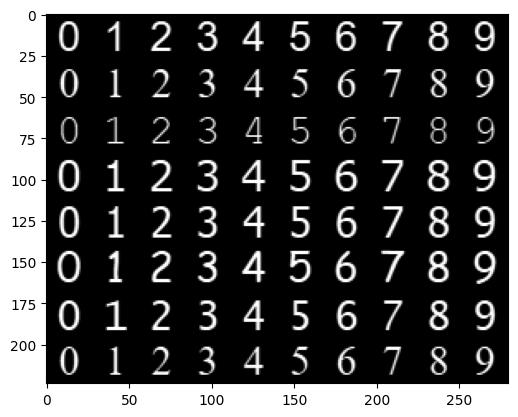

In [2]:
# get image + invert
image = cv.imread('../data/personal/digits.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = 255 - image
plt.imshow(image, cmap='gray')


Text(0.5, 0.98, 'First 10 digits')

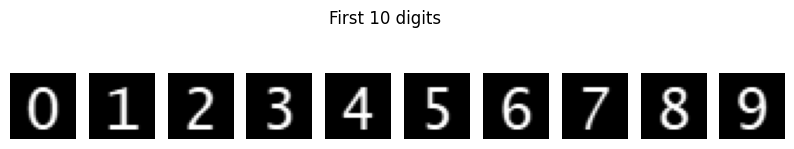

In [3]:
# split digits
h, w = image.shape
rows = h // 28
cols = w // 28

digits = []

for r in range(rows):
    for c in range(cols):
        digits.append(image[r * 28:(r + 1) * 28, c * 28:(c + 1) * 28])

plt.figure(figsize=(10, 2))
for i in range(min(10, len(digits))):
    plt.subplot(1, 10, i+1)
    plt.imshow(digits[i + 60], cmap='gray')
    plt.axis('off')
plt.suptitle('First 10 digits')

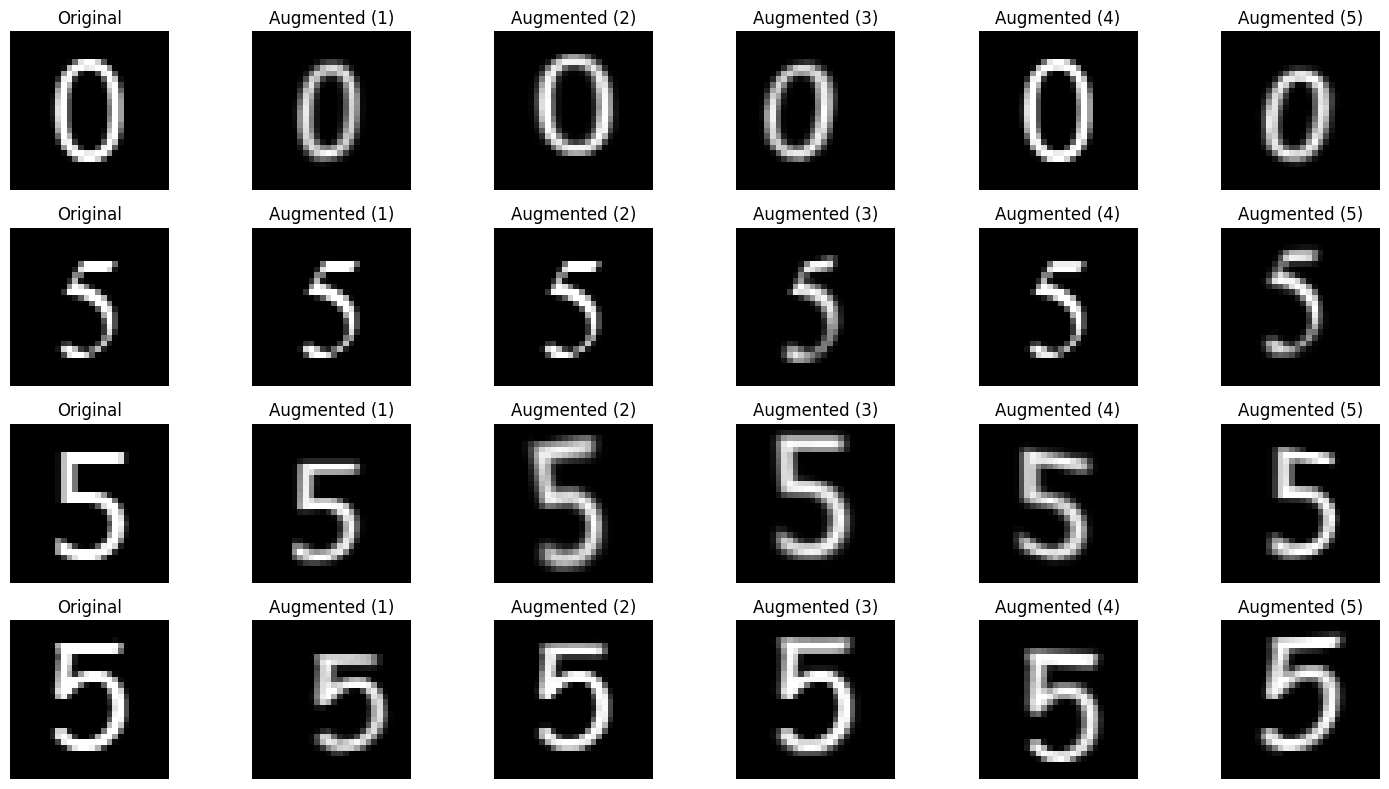

In [4]:
# augment by transformations

# --- Parameters ---
AGGRESSIVITY = 0.5

# Probabilities for each effect
PROB_PERSPECTIVE = 0.6
PROB_STRETCH = 0.5
PROB_DISTORTION = 0.5

# Perspective: maximum pixels a corner can shift
MAX_PERSP_SHIFT = int(6 * AGGRESSIVITY)
# Stretch: percentage of stretch (+/-)
MAX_STRETCH = 0.25 * AGGRESSIVITY
# Distortion: coefficient for barrel/pincushion effect
MAX_DISTORT_K = 0.25 * AGGRESSIVITY

def transform_digit(img):
    h, w = img.shape
    aug_img = img.copy()

    # 1. Perspective Transform
    if random.random() < PROB_PERSPECTIVE:
        src_points = np.float32([[0,0], [w, 0], [0, h], [w, h]])

        dx = np.random.uniform(-MAX_PERSP_SHIFT, MAX_PERSP_SHIFT, 4)
        dy = np.random.uniform(-MAX_PERSP_SHIFT, MAX_PERSP_SHIFT, 4)

        dst_points = src_points + np.stack([dx, dy], axis=1).astype(np.float32)

        M = cv.getPerspectiveTransform(src_points, dst_points)
        aug_img = cv.warpPerspective(aug_img, M, (w, h), borderMode=cv.BORDER_CONSTANT, borderValue=0)

    # 2. Stretching
    if random.random() < PROB_STRETCH:
        # Generate independent scales
        scale_x = 1.0 + np.random.uniform(-MAX_STRETCH, MAX_STRETCH)
        scale_y = 1.0 + np.random.uniform(-MAX_STRETCH, MAX_STRETCH)

        new_w = int(w * scale_x)
        new_h = int(h * scale_y)

        # Resize
        if new_w > 0 and new_h > 0:
            stretched = cv.resize(aug_img, (new_w, new_h), interpolation=cv.INTER_LINEAR)

            # Center stretched img back to 28x28
            canvas = np.zeros((h, w), dtype=aug_img.dtype)

            y_off = (h - new_h) // 2
            x_off = (w - new_w) // 2

            c_y1 = max(0, y_off); c_y2 = min(h, y_off + new_h)
            c_x1 = max(0, x_off); c_x2 = min(w, x_off + new_w)

            copy_h = c_y2 - c_y1
            copy_w = c_x2 - c_x1

            s_y1 = max(0, -y_off); s_y2 = s_y1 + copy_h
            s_x1 = max(0, -x_off); s_x2 = s_x1 + copy_w

            if copy_h > 0 and copy_h > 0:
                canvas[c_y1:c_y2, c_x1:c_x2] = stretched[s_y1:s_y2, s_x1:s_x2]

            aug_img = canvas

    # 3. Radial Distortion
    if random.random() < PROB_DISTORTION:
        # k > 0: Barrel (fat in the middle)
        # k < 0: Pincushion (pinched in the middle)
        k = np.random.uniform(-MAX_DISTORT_K, MAX_DISTORT_K)

        cx, cy = w / 2, h / 2

        map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
        map_x = map_x.astype(np.float32)
        map_y = map_y.astype(np.float32)

        norm_x = (map_x - cx) / cx
        norm_y = (map_y - cy) / cy
        r2 = norm_x**2 + norm_y**2

        # Apply distortion formula: x_new = x_old * (1 + k * r^2)
        factor = 1.0 + k * r2

        map_x_distorted = cx + (map_x - cx) * factor
        map_y_distorted = cy + (map_y - cy) * factor

        aug_img = cv.remap(aug_img, map_x_distorted, map_y_distorted,
                           interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=0)
    return aug_img

# Show augmentation on a few digits
sample_indices = [0, 15, 35, 55]
plt.figure(figsize=(15, 8))

for idx, digit_idx in enumerate(sample_indices):
    if digit_idx < len(digits):
        base_digit = digits[digit_idx]

        plt.subplot(len(sample_indices), 6, idx * 6 + 1)
        plt.title("Original")
        plt.imshow(base_digit, cmap='gray')
        plt.axis('off')

        for i in range(5):
            aug = transform_digit(base_digit)
            plt.subplot(len(sample_indices), 6, idx * 6 + i + 2)
            plt.title(f"Augmented ({i+1})")
            plt.imshow(aug, cmap='gray')
            plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# augment by adding noise

# --- Parameters ---
NOISE_AGGRESSIVITY = 0.5  # Master dial for noise intensity (0.0 to 1.0)

# Probabilities
PROB_SALT_PEPPER = 0.6
PROB_BLUR = 0.1
PROB_STAINS = 0.3

# Salt/Pepper: Percentage of pixels to randomly flip to white/black
SP_AMOUNT = 0.05 * NOISE_AGGRESSIVITY
# Blur: Max kernel size (must be odd)
MAX_BLUR_K = 3
# Stains: Max number of random spots and their size
MAX_STAIN_COUNT = 3
MAX_STAIN_RADIUS = int(3 * NOISE_AGGRESSIVITY)

def add_texture_noise(img):
    """
    Applies random noise, blur, and stains to a 28x28 grayscale image.
    Expects img values in range [0, 255].
    """
    h, w = img.shape
    noisy_img = img.copy()

    # 1. Salt & Pepper Noise (Simulates paper grain / sensor noise)
    if random.random() < PROB_SALT_PEPPER:
        # Create a random matrix of floats [0, 1)
        prob_mat = np.random.rand(h, w)

        # Salt (White dots) - simulate dust on the sensor
        # If random val < (amount / 2), turn pixel white
        noisy_img[prob_mat < (SP_AMOUNT / 2)] = 255

        # Pepper (Black dots) - simulate ink spots or dark grain
        # If random val > 1 - (amount / 2), turn pixel black
        noisy_img[prob_mat > (1 - (SP_AMOUNT / 2))] = 0

    # 2. Random "Stains" (Simulates ink blots or larger paper defects)
    if random.random() < PROB_STAINS:
        num_stains = random.randint(1, MAX_STAIN_COUNT)
        for _ in range(num_stains):
            center_x = random.randint(0, w)
            center_y = random.randint(0, h)
            # Ensure radius is at least 1
            radius = random.randint(1, max(1, MAX_STAIN_RADIUS))

            # Randomly decide if the stain is white (paper noise) or black (ink blot)
            color = random.choice([0, 255])

            # -1 fills the circle
            cv.circle(noisy_img, (center_x, center_y), radius, color, -1)

    # 3. Gaussian Blur (Simulates out-of-focus camera)
    # We apply this LAST so it blurs the noise/stains slightly too, making them look natural
    if random.random() < PROB_BLUR:
        # Randomly choose kernel size: 1 (no blur), 3 (light blur), etc.
        # Ensure kernel is odd and at least 1
        k_size = random.choice([1, 3])
        if k_size > 1:
            noisy_img = cv.GaussianBlur(noisy_img, (k_size, k_size), 0)

    return noisy_img

# Show noise on a few digits
sample_indices = [0, 15, 32, 57]
plt.figure(figsize=(15, 8))

for idx, digit_idx in enumerate(sample_indices):
    if digit_idx < len(digits):
        base_digit = digits[digit_idx]

        plt.subplot(len(sample_indices), 6, idx * 6 + 1)
        plt.title("Original")
        plt.imshow(base_digit, cmap='gray')
        plt.axis('off')

        for i in range(5):
            noisy = add_texture_noise(base_digit)
            plt.subplot(len(sample_indices), 6, idx * 6 + i + 2)
            plt.title(f"Noisy ({i+1})")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# create augmented dataset
digits_dataset = []
for i in range(10):
    for j in range(8):
        for k in range(100):
            digits_dataset.append((transform_digit(digits[i + 10 * j]), i))

In [10]:
digits_dataset[8000]

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          46, 193, 123,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0

In [16]:
images, labels = zip(*digits_dataset)
x = torch.tensor(np.array(images))
y = torch.tensor(labels)
torch.save((x, y), '../data/personal/digits_test.pt')